In [1]:
#Importing necessary libraries
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
from sklearn.preprocessing import LabelEncoder
import random
import math
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle

In [2]:
#Connecting to GitHub
!git clone https://github.com/robertsarnet/IDS-project.git
%cd IDS-project/IDS_data
!dir

c:\Users\rober.DESKTOP-ASC95IC\Downloads\IDS-project\IDS_data


fatal: destination path 'IDS-project' already exists and is not an empty directory.


 Volume in drive C has no label.
 Volume Serial Number is B4C1-16F0

 Directory of c:\Users\rober.DESKTOP-ASC95IC\Downloads\IDS-project\IDS_data

16/12/2024  00:43    <DIR>          .
16/12/2024  00:43    <DIR>          ..
12/12/2024  10:19    <DIR>          test
12/12/2024  10:20    <DIR>          train
12/12/2024  10:20    <DIR>          valid
               0 File(s)              0 bytes
               5 Dir(s)   7,243,468,800 bytes free


In [3]:
print("Current working directory:", os.getcwd())

Current working directory: c:\Users\rober.DESKTOP-ASC95IC\Downloads\IDS-project\IDS_data


In [4]:
#Specifying folders
train_folder = "train"
val_folder = "valid"
test_folder = "test"

In [5]:
#Creating a dictionary, with plant species as keys and diseases as values.
plants_diseases = {}

for imfolder in os.listdir(train_folder):
    folder_path = os.path.join(train_folder, imfolder)
    if os.path.isdir(folder_path):
        species = imfolder.strip().split("___")[0]
        disease = imfolder.strip().split("___")[1]
        if species not in plants_diseases:
            plants_diseases[species] = []
        if disease not in plants_diseases[species]:
            plants_diseases[species].append(disease)

In [6]:
#Creating a list of unique species for encoding.
species_categories = []

for imfolder in os.listdir(train_folder): #Go through all folders in the train folder (each folder represents a category in a format "'species_name'___'disease_name'")
    folder_path = os.path.join(train_folder, imfolder)
    if os.path.isdir(folder_path):
        if imfolder.strip().split("___")[0] not in species_categories:
            species_categories.append(imfolder.strip().split("___")[0])

label_encoder_species = LabelEncoder()
label_encoder_species.fit(species_categories)  #Assigning a number to each species class.

with open('label_encoder_species.pkl', 'wb') as file:
    pickle.dump(label_encoder_species, file)

In [7]:
#A function to read in the picture data and corresponding species labels for the training, validation and test data
#The training, validation and test data are in separate folders, which all have subfolders of different classes
#Each subfolder contains images of this class and the folder name represetns the class (e.g "Apple___healthy" has images of healthy apple leaves)
#Actually the function is a generator that yields data in batches, because there are a lot of pictures and otherwise the system ran out of RAM

def image_data_species(folder, batch_size=32, encoder = label_encoder_species):
    image_paths = [] #collecting all image paths to a list
    species_labels = [] #collecting all species labels of the images to a list (as strings, extracted from file names)

    for imfolder in os.listdir(folder): #Go through all subfolders in the specified (train/validation/test) folder (each subfolder represents a category)
        folder_path = os.path.join(folder, imfolder)
        if os.path.isdir(folder_path):
            for imfile in os.listdir(folder_path): #Go through all of the files (photos) in the subfolder
                image_path = os.path.join(folder_path, imfile)
                if os.path.isfile(image_path):
                    image_paths.append(image_path)
                    species_labels.append(imfolder.strip().split("___")[0])


    def generator(seed=None):
        if seed is None:
            random.seed(7)

        # Shuffle the data by shuffling the indexes
        indices = list(range(len(image_paths)))
        random.shuffle(indices)

        while True:
            # Yield data in batches
            X_batch = []
            y_batch = []

            for i in indices:
                image_path = image_paths[i]
                label = species_labels[i]

                img = cv2.imread(image_path) #Load in the image data (256x256x3 matrix) with cv2

                if img is not None:
                    if img.shape != (256, 256, 3):
                        img = cv2.resize(img, (256, 256)) #If an image doesnt have the regular size, resize it
                    img = img / 255.0  # Normalize the image to the range [0, 1], because neural networks work better with numbers in this range

                    X_batch.append(img)
                    y_batch.append(label)

                # Full batch
                if len(X_batch) >= batch_size:
                    X_batch = np.array(X_batch) #Convert to numpy array
                    y_batch = encoder.transform(y_batch)  #Convert string labels to integers
                    y_batch = np.array(y_batch)

                    yield X_batch, y_batch

                    X_batch = []
                    y_batch = []

        #All remaining images that aren't part of a full batch
            if X_batch:
                X_batch = np.array(X_batch)
                y_batch = encoder.transform(y_batch)
                y_batch = np.array(y_batch)

                yield X_batch, y_batch

    return generator(seed=7), image_paths

In [8]:
#Creating an initial model, that will be trained
model_species = models.Sequential([
    layers.InputLayer(shape=(256, 256, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(species_categories), activation='softmax')
])

#Compiling the model
model_species.compile(optimizer=optimizers.Adam(learning_rate = 0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [9]:
#Getting training and validation data, that are prepared for learning
train_data_species, image_paths_train_species = image_data_species(train_folder, 32, label_encoder_species)
val_data_species, image_paths_val_species = image_data_species(val_folder, 32, label_encoder_species)

#Calculating the number of steps (batches) per epoch
train_steps_species= int(math.ceil(len(image_paths_train_species) / 32))
val_steps_species = int(math.ceil(len(image_paths_val_species) / 32))

In [10]:
#There were some mild fluctuations in training the model (i.e better validation accuracy after 4th than 5th epoch), thus, callback is used to save the weights that had the best validation accuracy
checkpoint_path = "best.weights.h5" #file path to save weights

# Creating the ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    verbose=1
    )

#Training the model
history_species = model_species.fit(
    train_data_species,
    steps_per_epoch=train_steps_species,
    epochs=5,
    validation_data=val_data_species,
    validation_steps=val_steps_species,
    verbose=1,
    callbacks=[checkpoint_callback]
)

Epoch 1/5
1714/1714 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5627 - loss: 1.2856
Epoch 1: val_accuracy improved from -inf to 0.86196, saving model to best.weights.h5
1714/1714 ━━━━━━━━━━━━━━━━━━━━ 2621s 2s/step - accuracy: 0.5628 - loss: 1.2853 - val_accuracy: 0.8620 - val_loss: 0.4060
Epoch 2/5
1714/1714 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8239 - loss: 0.5122
Epoch 2: val_accuracy improved from 0.86196 to 0.92982, saving model to best.weights.h5
1714/1714 ━━━━━━━━━━━━━━━━━━━━ 2340s 1s/step - accuracy: 0.8239 - loss: 0.5121 - val_accuracy: 0.9298 - val_loss: 0.2214
Epoch 3/5
1714/1714 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8844 - loss: 0.3346
Epoch 3: val_accuracy improved from 0.92982 to 0.94227, saving model to best.weights.h5
1714/1714 ━━━━━━━━━━━━━━━━━━━━ 2352s 1s/step - accuracy: 0.8844 - loss: 0.3346 - val_accuracy: 0.9423 - val_loss: 0.1882
Epoch 4/5
1714/1714 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9116 - loss: 0.2622
Epoch 4: val_accuracy did not im

In [17]:
filename = f"model_species.keras"
model_species.save(filename)

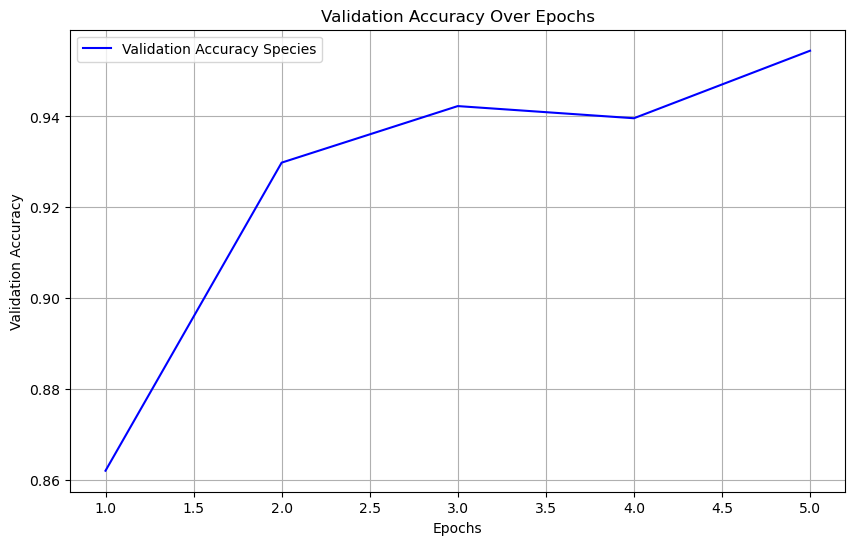

In [12]:
#Extracting validation accuracy from the history object
val_accuracy_species = history_species.history['val_accuracy']

#Plotting the validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(val_accuracy_species) + 1), val_accuracy_species, label='Validation Accuracy Species', color='blue')
plt.title('Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.grid(True)
plt.legend()
plt.show()

In [13]:
#A function to read in the picture data and corresponding disease labels for the training, validation and test data
#Similar to image_data_species function, now just using diseases instead of species
def image_data_disease(folder, species, batch_size=32):
    image_paths = []
    disease_labels = []

    for imfolder in os.listdir(folder): #Go through all folders in the train folder (each folder represents a category)
        folder_path = os.path.join(folder, imfolder)
        if os.path.isdir(folder_path):
            species_name, disease_name = imfolder.strip().split("___")
            if species_name == species:
              for imfile in os.listdir(folder_path): #Go through all of the files (photos) in the subfolder
                  image_path = os.path.join(folder_path, imfile)
                  if os.path.isfile(image_path):
                      image_paths.append(image_path)
                      disease_labels.append(disease_name)

    unique_labels = list(set(disease_labels))

    label_encoder_disease = LabelEncoder()
    label_encoder_disease.fit(unique_labels)  #Assigning a number to each disease class

    file_name = f"label_encoder_{species}.pkl"
    with open(file_name, 'wb') as file:
        pickle.dump(label_encoder_disease, file)

    def generator(seed=None):
        if seed is None:
            random.seed(7)

        # Shuffle the data by shuffling the indexes
        indices = list(range(len(image_paths)))
        random.shuffle(indices)

        while True:
            # Yield data in batches
            X_batch = []
            y_batch = []

            for i in indices:
                image_path = image_paths[i]
                label = disease_labels[i]

                img = cv2.imread(image_path) #Load in the image data (256x256x3 matrix) with cv2

                if img is not None:
                    if img.shape != (256, 256, 3):
                        img = cv2.resize(img, (256, 256)) #If an image doesnt have the regular size, resize it
                    img = img / 255.0  # Normalize the image to the range [0, 1], because neural networks work better with numbers in this range

                    X_batch.append(img)
                    y_batch.append(label)

                # Full batch
                if len(X_batch) >= batch_size:
                    X_batch = np.array(X_batch) #Convert to numpy array

                    y_batch = label_encoder_disease.transform(y_batch)  #Convert string labels to integers
                    y_batch = np.array(y_batch)


                    yield X_batch, y_batch

                    X_batch = []
                    y_batch = []

        #All remaining images that aren't part of a full batch
            if X_batch:
                X_batch = np.array(X_batch) #Convert to numpy array

                y_batch = label_encoder_disease.transform(y_batch)  #Convert string labels to integers
                y_batch = np.array(y_batch)

                yield X_batch, y_batch

    return generator(seed=7), image_paths, label_encoder_disease, unique_labels

Epoch 1/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6131 - loss: 1.1311
Epoch 1: val_accuracy improved from -inf to 0.83801, saving model to best.weights.h5
219/219 ━━━━━━━━━━━━━━━━━━━━ 266s 1s/step - accuracy: 0.6137 - loss: 1.1290 - val_accuracy: 0.8380 - val_loss: 0.4430
Epoch 2/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8798 - loss: 0.3380
Epoch 2: val_accuracy improved from 0.83801 to 0.92330, saving model to best.weights.h5
219/219 ━━━━━━━━━━━━━━━━━━━━ 267s 1s/step - accuracy: 0.8799 - loss: 0.3378 - val_accuracy: 0.9233 - val_loss: 0.1875
Epoch 3/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9286 - loss: 0.2075
Epoch 3: val_accuracy improved from 0.92330 to 0.94489, saving model to best.weights.h5
219/219 ━━━━━━━━━━━━━━━━━━━━ 266s 1s/step - accuracy: 0.9286 - loss: 0.2074 - val_accuracy: 0.9449 - val_loss: 0.1456
Epoch 4/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9406 - loss: 0.1696
Epoch 4: val_accuracy improved from 0.94489 to 0.

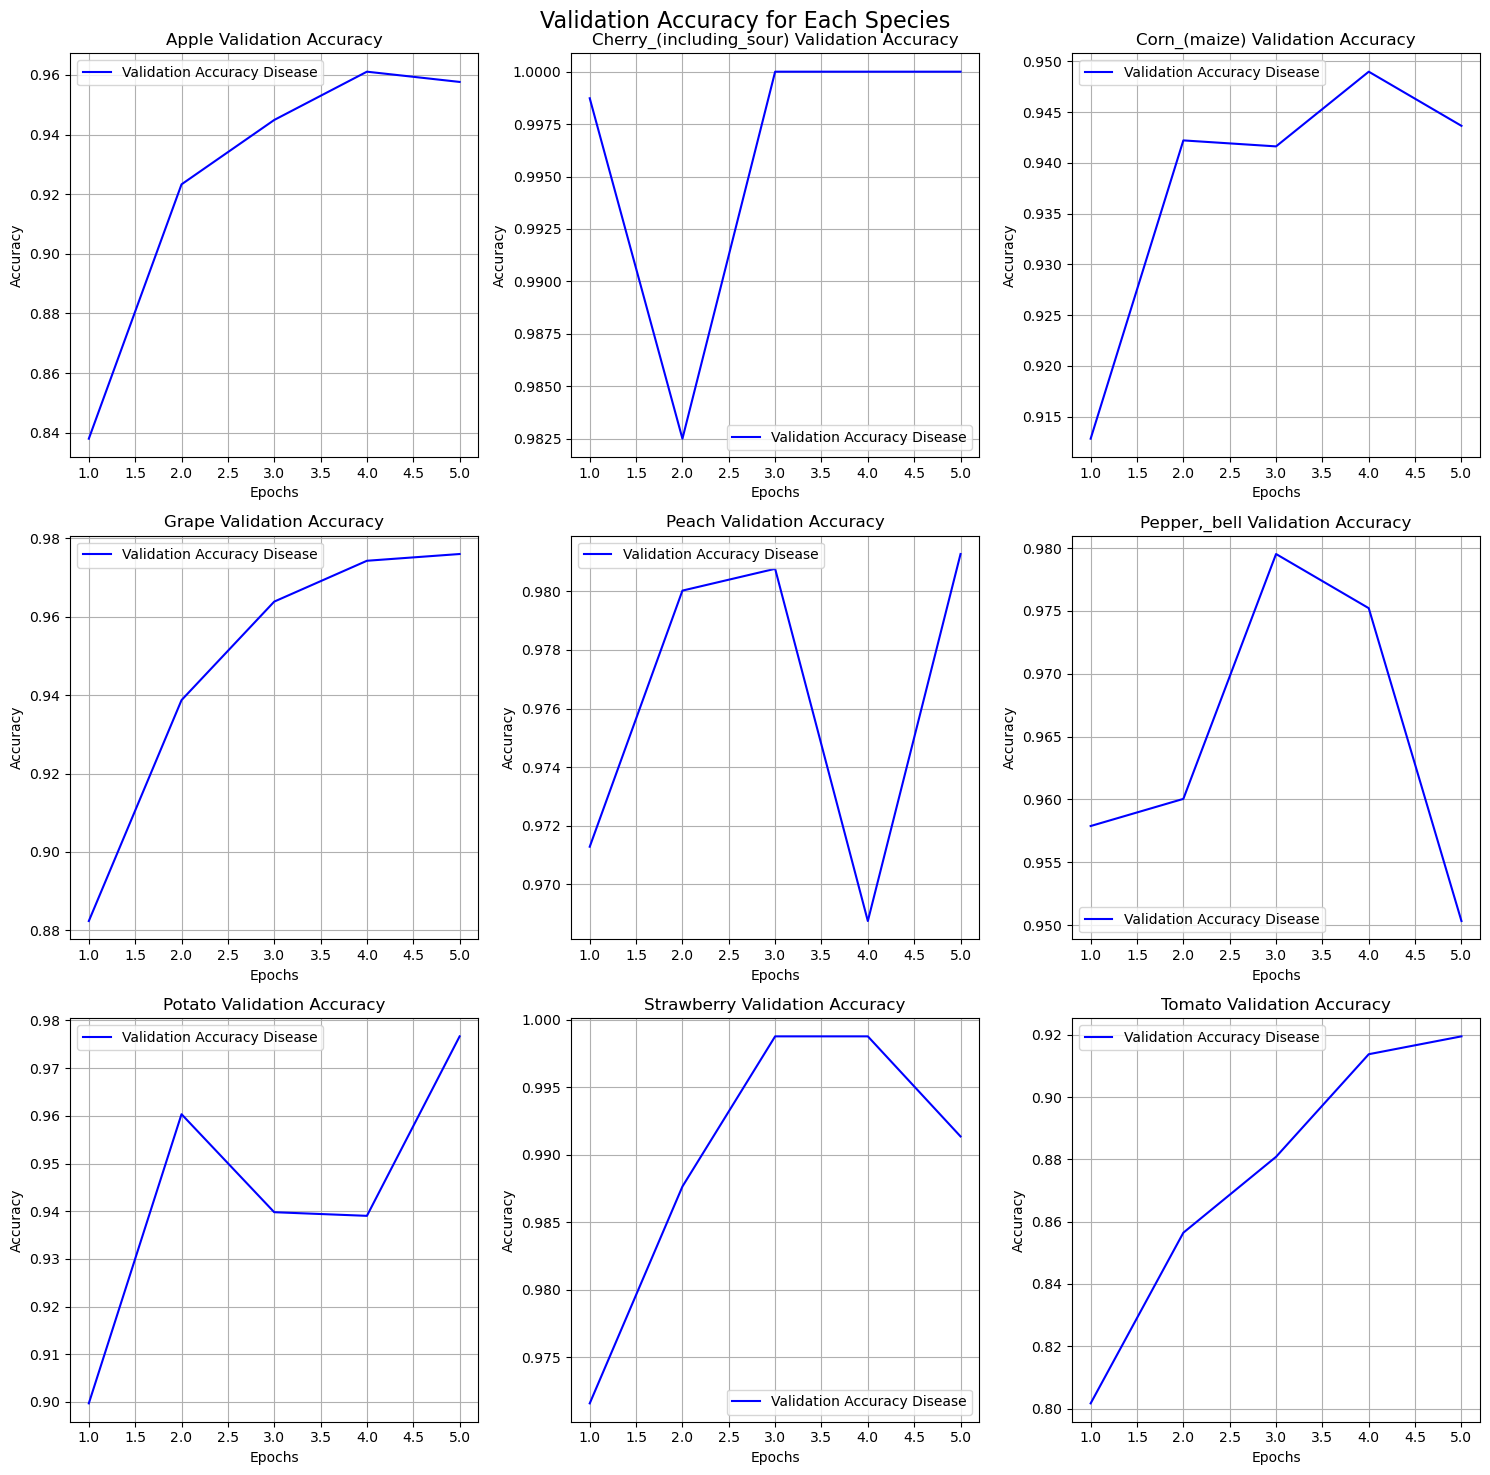

In [14]:
#Making different models for each species to predict the DISEASE based on a known species
disease_models = {}

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
fig.suptitle('Validation Accuracy for Each Species', fontsize=16)


for i, (species, disease) in enumerate(plants_diseases.items()): #Iterating over the species
    train_data_disease, image_paths_train_disease, encoder, labels = image_data_disease(train_folder, species, 32) #Getting training and validation data, that are prepared for learning
    val_data_disease, image_paths_val_disease, encoder, labels = image_data_disease(val_folder, species, 32)

    #Same netowrk structure as before, except for output layer
    model_disease = models.Sequential([
        layers.InputLayer(shape=(256, 256, 3)),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(len(disease), activation='softmax') #Output layer has a different number of neurons depending on how many classes of diseases the given plant has
    ])

    #Compiling the model
    model_disease.compile(optimizer=optimizers.Adam(),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Calculating the number of steps (batches) per epoch
    train_steps_disease= int(math.ceil(len(image_paths_train_disease) / 32))
    val_steps_disease = int(math.ceil(len(image_paths_val_disease) / 32))

  #There were some mild fluctuations in training the models (i.e better validation accuracy after 2nd than 3rd epoch), thus, callback is used to save the weights that had the best validation accuracy
    checkpoint_path = "best.weights.h5" #file path to save weights

    # Creating the ModelCheckpoint callback
    checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=True,
        mode='max',
        verbose=1
        )

    history_disease = model_disease.fit(
        train_data_disease,
        steps_per_epoch=train_steps_disease,
        epochs=5,
        validation_data=val_data_disease,
        validation_steps=val_steps_disease,
        verbose=1,
        callbacks=[checkpoint_callback]    # Adding the callback to fit
    )

    #Saving the model
    filename = f"model_{species}.keras"
    model_disease.save(filename)

    row = i // 3
    col = i % 3

    val_accuracy_disease = history_disease.history['val_accuracy']

    # Plot the validation accuracy
    axes[row, col].plot(range(1, len(val_accuracy_disease) + 1), val_accuracy_disease, label='Validation Accuracy Disease', color='blue')
    axes[row, col].set_title(f'{species} Validation Accuracy')
    axes[row, col].set_xlabel('Epochs')
    axes[row, col].set_ylabel('Accuracy')
    axes[row, col].grid(True)
    axes[row, col].legend()

    disease_models[species] = [model_disease, encoder, labels] #Adding the model and encoder to the dictionary.

plt.tight_layout()
plt.show() #Plotting the validation accuracy

In [26]:
for species, values in disease_models.items():
    filename = f"model_{species}.keras"
    values[0].save(filename)
    file_name = f"label_encoder_{species}.pkl"
    with open(file_name, 'wb') as file:
        pickle.dump(values[1], file)

In [ ]:
#Making a model taht predicts the SPECIES AND DISEASE of the plant leaf
plants = {}

for imfolder in os.listdir(train_folder):
    folder_path = os.path.join(train_folder, imfolder)
    if os.path.isdir(folder_path):
        plant = imfolder.strip().split("___")[0].split("_")[0].strip(",")
        if plant in plants:
            plants[plant].append(imfolder)
        else:
            plants[plant] = [imfolder]

categories_label = []

# The class names (folder names) must be encoded to numerical values
for imfolder in os.listdir(train_folder):
    folder_path = os.path.join(train_folder, imfolder)
    if os.path.isdir(folder_path):
        if imfolder not in categories_label:
            categories_label.append(imfolder)

print(len(categories_label))

label_encoder_combined = LabelEncoder()
label_encoder_combined.fit(categories_label)  # Assign a number to each class

with open('label_encoder_all.pkl', 'wb') as file:
      pickle.dump(label_encoder_combined, file)

def image_data(folder, batch_size=32, encoder = label_encoder_combined):
    image_paths = []
    labels = []

    # Collect image paths and labels from all subfolders
    for imfolder in os.listdir(folder): #Go through all folders in the train folder (each folder represents a category)
        folder_path = os.path.join(folder, imfolder)
        if os.path.isdir(folder_path):
            for imfile in os.listdir(folder_path): #Go through all of the files (photos) in the subfolder
                image_path = os.path.join(folder_path, imfile)
                if os.path.isfile(image_path):
                    image_paths.append(image_path)
                    labels.append(imfolder)


# Shuffle the data by shuffling the indexes
    def generator(seed=None):
        if seed is None:
            random.seed(7)

        indices = list(range(len(image_paths)))
        random.shuffle(indices)

        while True:
            # Yield data in batches
            X_batch = []
            y_batch = []

            for i in indices:
                image_path = image_paths[i]
                label = labels[i]

                img = cv2.imread(image_path) #Load in the image data (256x256x3 matrix) with cv2

                if img is not None:
                    if img.shape != (256, 256, 3):
                        img = cv2.resize(img, (256, 256)) #If an image doesnt have the regular size, resize it
                    img = img / 255.0  # Normalize the image to the range [0, 1], because neural networks work better with numbers in this range

                    X_batch.append(img)
                    y_batch.append(label)

                # Full batch
                if len(X_batch) >= batch_size:
                    X_batch = np.array(X_batch) #Convert to numpy array

                    y_batch = encoder.transform(y_batch)  #Convert string labels to integers
                    y_batch = np.array(y_batch)

                    yield X_batch, y_batch

                    X_batch = []
                    y_batch = []

        #All remaining images that aren't part of a full batch
            if X_batch:
                X_batch = np.array(X_batch) #Convert to numpy array

                y_batch = encoder.transform(y_batch)  #Convert string labels to integers
                y_batch = np.array(y_batch)

                yield X_batch, y_batch

    return generator(seed=7), image_paths

train_data, image_paths_train = image_data(train_folder, 32, label_encoder_combined)
val_data, image_paths_val = image_data(val_folder, 32, label_encoder_combined)

#Defining a convolutional neural network model, again same structure as before
model_all = models.Sequential([
    layers.InputLayer(shape=(256, 256, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(categories_label), activation='softmax')
])

#Compiling the model
model_all.compile(optimizer=optimizers.Adam(learning_rate = 0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Calculating the number of steps (batches) per epoch
train_steps = int(math.ceil(len(image_paths_train) / 32))
val_steps = int(math.ceil(len(image_paths_val) / 32))

In [16]:
#Kõikide klasside klassifitseerija
history_combined = model_all.fit(
    train_data,
    steps_per_epoch=train_steps,
    epochs=5,
    validation_data=val_data,
    validation_steps=val_steps,
    verbose = 1
)

Epoch 1/5
1714/1714 ━━━━━━━━━━━━━━━━━━━━ 2164s 1s/step - accuracy: 0.3405 - loss: 2.3170 - val_accuracy: 0.7627 - val_loss: 0.7572
Epoch 2/5
1714/1714 ━━━━━━━━━━━━━━━━━━━━ 2198s 1s/step - accuracy: 0.7195 - loss: 0.8881 - val_accuracy: 0.8804 - val_loss: 0.3663
Epoch 3/5
 231/1714 ━━━━━━━━━━━━━━━━━━━━ 27:47 1s/step - accuracy: 0.7932 - loss: 0.6320

KeyboardInterrupt: 

In [17]:
#Saving the model
filename = f"model_all.keras"
model_all.save(filename)

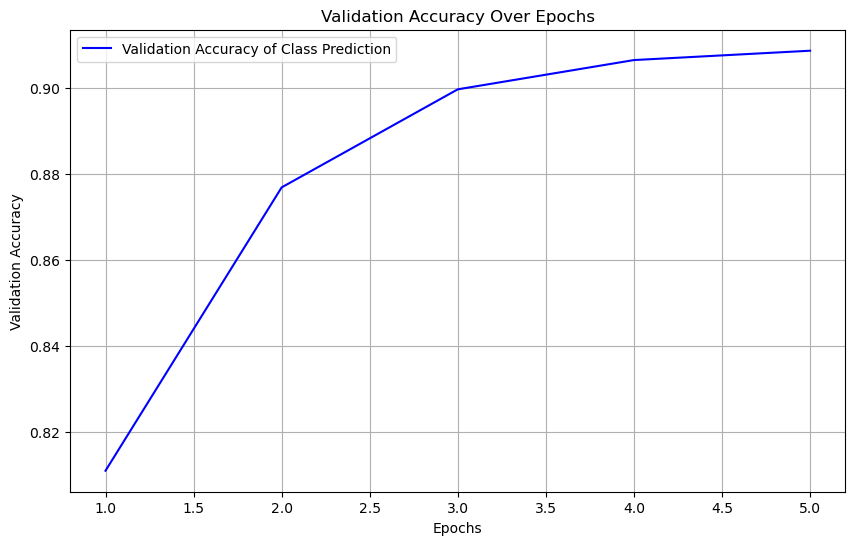

In [18]:
#Extracting validation accuracy from the history object
val_accuracy_combined = history_combined.history['val_accuracy']

#Plotting the validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(val_accuracy_combined) + 1), val_accuracy_combined, label='Validation Accuracy of Class Prediction', color='blue')
plt.title('Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.grid(True)
plt.legend()
plt.show()